In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels as ss

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
pd.options.display.max_seq_items = 2000
pd.options.display.max_columns = 500
pd.options.display.max_rows = 800
pd.options.display.max_colwidth = 200
pd.options.display.width = 800

In [4]:
# Data source:
# https://www.ncei.noaa.gov/access/monitoring/wildfires/

In [5]:
current_path = os.getcwd()

In [6]:
raw = pd.read_csv(os.path.join(current_path, "data", "data.csv"), delimiter=",", engine="python")
print("Shape of the table (rows, columns) = ", raw.shape)
raw.tail()

Shape of the table (rows, columns) =  (271, 4)


,Date,Acres Burned,Number of Fires,Acres Burned per Fire
266,202203,368065,7694,47.84
267,202204,602491,7543,79.87
268,202205,799903,5722,139.79
269,202206,2002408,5880,340.55
270,202207,1790284,5300,337.79


## Exploration and transformations

In [7]:
raw.dtypes

Date                       int64
Acres Burned               int64
Number of Fires            int64
Acres Burned per Fire    float64
dtype: object

In [8]:
raw.isna().sum()

Date                     0
Acres Burned             0
Number of Fires          0
Acres Burned per Fire    0
dtype: int64

In [9]:
# Convert "Date" column to datetime
raw["Date"] = pd.to_datetime(raw["Date"], format="%Y%m")

In [10]:
raw.dtypes

Date                     datetime64[ns]
Acres Burned                      int64
Number of Fires                   int64
Acres Burned per Fire           float64
dtype: object

In [11]:
raw.head()

,Date,Acres Burned,Number of Fires,Acres Burned per Fire
0,2000-01-01,40757,2796,14.58
1,2000-02-01,168210,5671,29.66
2,2000-03-01,340899,10312,33.06
3,2000-04-01,182713,9236,19.78
4,2000-05-01,294493,11850,24.85


In [12]:
df = raw.copy()

In [13]:
# Use "Date" as index
df.set_index("Date", inplace=True)

In [14]:
df.head()

,Acres Burned,Number of Fires,Acres Burned per Fire
Date,,,
2000-01-01,40757,2796,14.58
2000-02-01,168210,5671,29.66
2000-03-01,340899,10312,33.06
2000-04-01,182713,9236,19.78
2000-05-01,294493,11850,24.85


In [15]:
print(len(df.index))
df.index

271


DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01', '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01', '2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01', '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01', '2002-12-01', '2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01', '2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01', '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01', '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01', '2005-09-01', '200

In [16]:
# Set the frequency of the index as "Months"
df = df.asfreq("MS")
df.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01', '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01', '2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01', '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01', '2002-12-01', '2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01', '2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01', '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01', '2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01', '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01', '2005-09-01', '200

In [17]:
# Create subframes
fires = pd.DataFrame(df["Number of Fires"])
force = pd.DataFrame(df["Acres Burned per Fire"])
acres = pd.DataFrame(df["Acres Burned"])
fires.head()

,Number of Fires
Date,
2000-01-01,2796
2000-02-01,5671
2000-03-01,10312
2000-04-01,9236
2000-05-01,11850


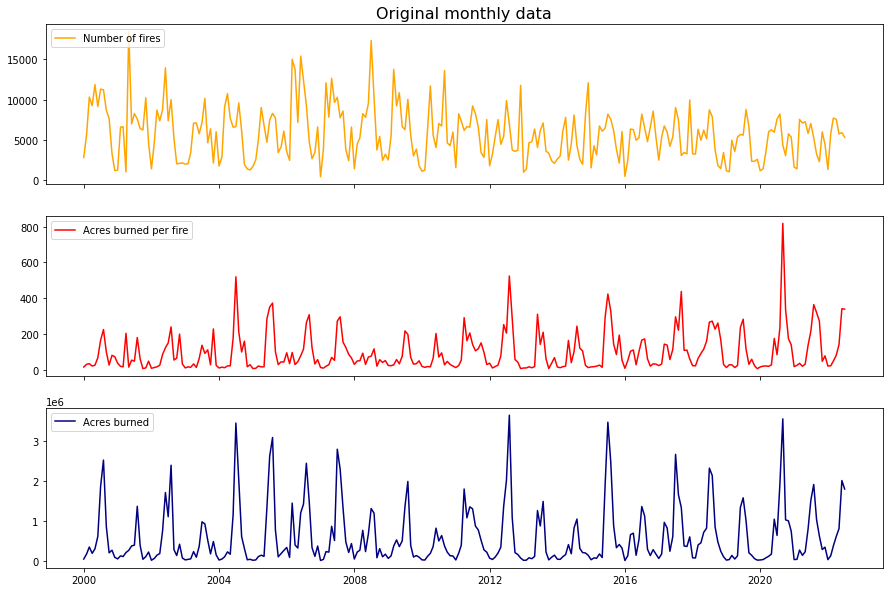

In [18]:
# Plot raw data
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].set_title("Original monthly data", fontsize=16)
axes[0].plot(fires, color='orange', label='Number of fires')
axes[0].legend(loc='upper left')

axes[1].plot(force, color='red', label='Acres burned per fire')
axes[1].legend(loc='upper left')

axes[2].plot(acres, color='navy', label='Acres burned')
axes[2].legend(loc='upper left')

plt.show()


In [19]:
# Annual resampling
acres_annual = acres.resample('Y').sum()
fires_annual = fires.resample('Y').sum()
force_annual = force.resample('Y').sum()

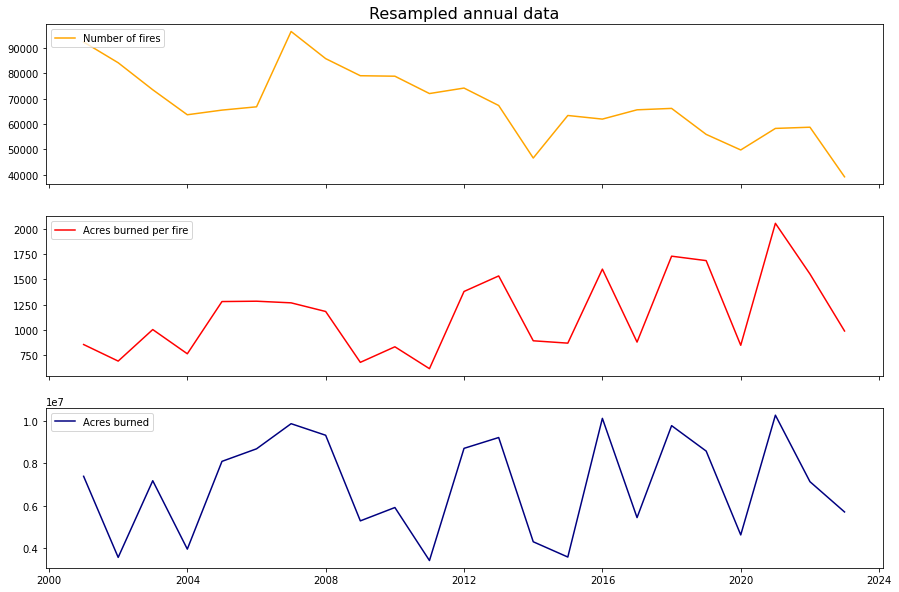

In [20]:
# Plot annual data
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].set_title("Resampled annual data", fontsize=16)
axes[0].plot(fires_annual, color='orange', label='Number of fires')
axes[0].legend(loc='upper left')

axes[1].plot(force_annual, color='red', label='Acres burned per fire')
axes[1].legend(loc='upper left')

axes[2].plot(acres_annual, color='navy', label='Acres burned')
axes[2].legend(loc='upper left')

plt.show()

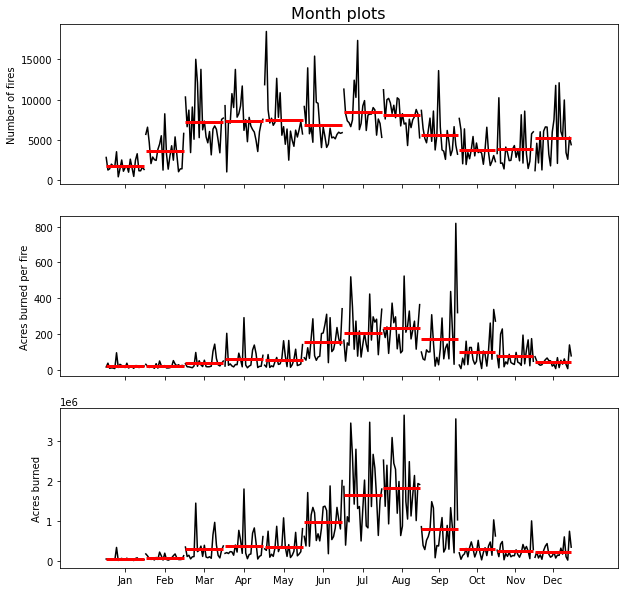

In [21]:
# Month plots
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)

axes[0].set_title("Month plots", fontsize=16)
month_plot(fires, ax=axes[0], ylabel='Number of fires');
month_plot(force, ax=axes[1], ylabel='Acres burned per fire');
month_plot(acres, ax=axes[2], ylabel='Acres burned');

plt.show()

## Decomposition

In [22]:
fires_decomposition = seasonal_decompose(x=fires, model='additive', period=12)
fires_trend = fires_decomposition.trend
fires_seasonal = fires_decomposition.seasonal
fires_residual = fires_decomposition.resid

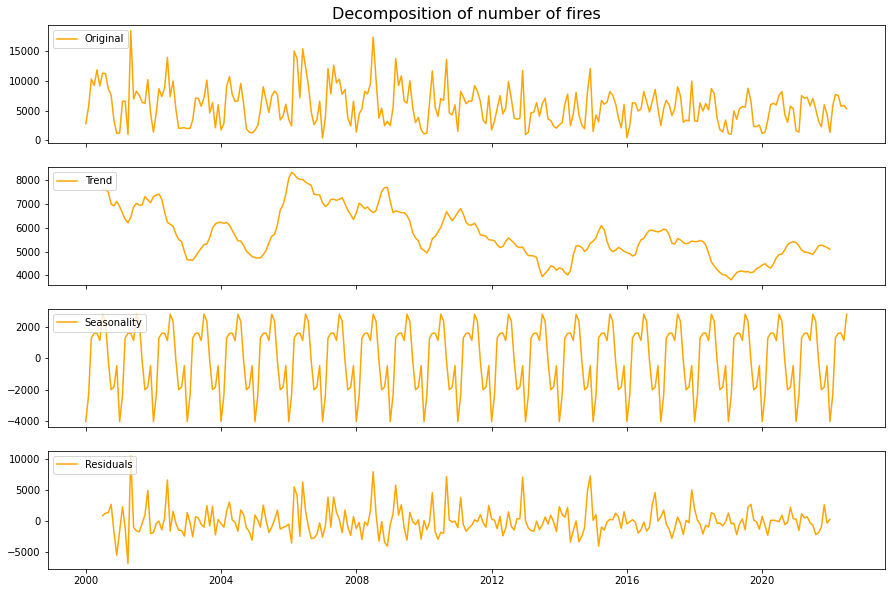

ADF =  -9.235056169925187
p-value =  1.6389637626871437e-15


In [23]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].set_title("Decomposition of number of fires", fontsize=16)
axes[0].plot(fires, color='orange', label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(fires_trend, color='orange', label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(fires_seasonal, color='orange', label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(fires_residual, color='orange', label='Residuals')
axes[3].legend(loc='upper left');

plt.show()
adf_fires, pvalue_fires, usedlag_fires, nobs_fires, critical_values_fires, icbest_fires = adfuller(fires_residual.dropna())
print("ADF = ", adf_fires)
print("p-value = ", pvalue_fires)

In [24]:
force_decomposition = seasonal_decompose(x=force, model='additive', period=12)
force_trend = force_decomposition.trend
force_seasonal = force_decomposition.seasonal
force_residual = force_decomposition.resid

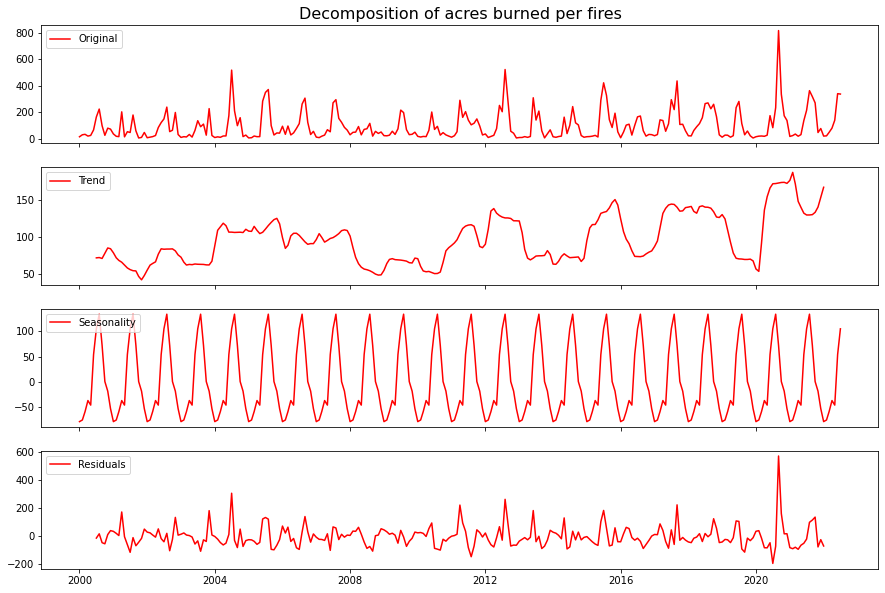

ADF =  -7.537606665563877
p-value =  3.4451499754018575e-11


In [25]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].set_title("Decomposition of acres burned per fires", fontsize=16)
axes[0].plot(force, color='red', label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(force_trend, color='red', label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(force_seasonal, color='red', label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(force_residual, color='red', label='Residuals')
axes[3].legend(loc='upper left');

plt.show()
adf_force, pvalue_force, usedlag_force, nobs_force, critical_values_force, icbest_force = adfuller(force_residual.dropna())
print("ADF = ", adf_force)
print("p-value = ", pvalue_force)

In [26]:
acres_decomposition = seasonal_decompose(x=acres, model='additive', period=12)
acres_trend = acres_decomposition.trend
acres_seasonal = acres_decomposition.seasonal
acres_residual = acres_decomposition.resid

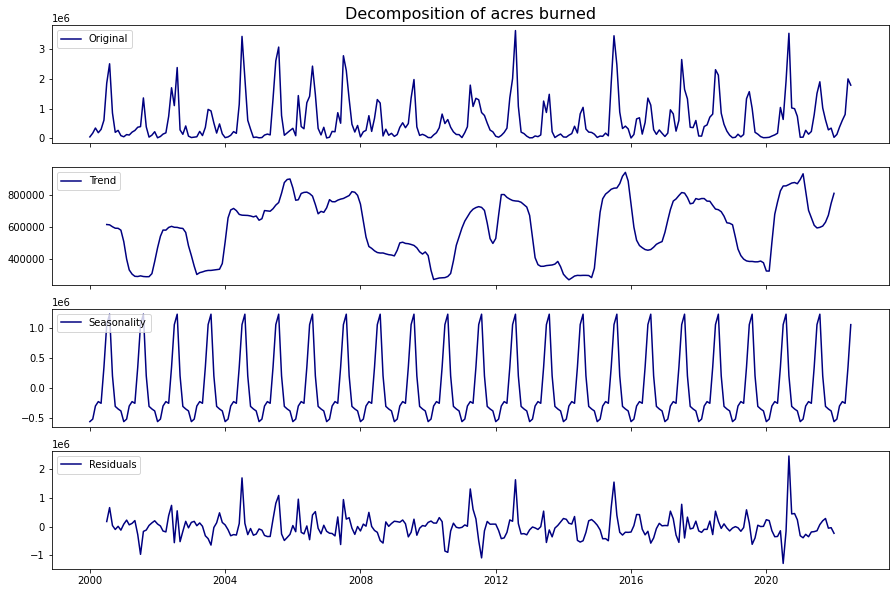

ADF =  -7.669011169486848
p-value =  1.6122467703458385e-11


In [27]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].set_title("Decomposition of acres burned", fontsize=16)
axes[0].plot(acres, color='navy', label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(acres_trend, color='navy', label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(acres_seasonal, color='navy', label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(acres_residual, color='navy', label='Residuals')
axes[3].legend(loc='upper left');

plt.show()
adf_acres, pvalue_acres, usedlag_acres, nobs_acres, critical_values_acres, icbest_acres = adfuller(acres_residual.dropna())
print("ADF = ", adf_acres)
print("p-value = ", pvalue_acres)

## Preparing for fit on trend

In [28]:
# First we need to drop the NaNs introduced by the seasonal decomposition (it's a moving average after all)
clean_fires_trend = fires_trend.dropna()

In [29]:
# Since numpy.polyfit requires a numerical (float or int) array and it cannot work with datetimes,
# we convert the x-axis from datetime to timestamp in seconds starting from 0 (year 2000).
# We can then "go back to years" while maintaining the numerical array by simply dividing by the number
# of seconds in 1 year (~ pie*10^7) and starting from the year 2000

# This array will serve as x-axis for all three features.

print(clean_fires_trend.index.year)
temp = clean_fires_trend.index.to_pydatetime()
timestamps_seconds = []
for time in temp:
    tstamp = time.timestamp()
    timestamps_seconds.append(tstamp)

x_axis = np.asarray(timestamps_seconds)
x_axis = x_axis - np.min(x_axis)
x_axis = x_axis / (np.pi*(10**7))
x_axis = x_axis + 2000
print(x_axis)

Int64Index([2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011,
            2011, 2011, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2014

In [30]:
# For the y-axis we keep the original unit and values
y_fires = clean_fires_trend.values

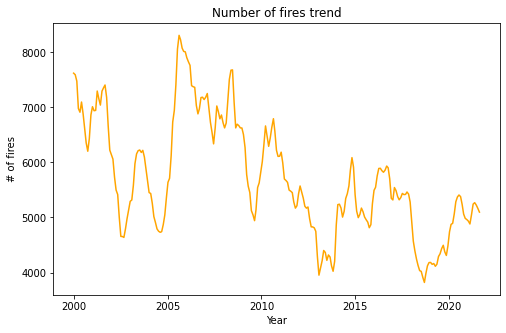

In [31]:
# Plot
plt.figure(figsize=(8,5))
plt.title("Number of fires trend")
plt.xlabel("Year")
plt.ylabel("# of fires")
plt.plot(x_axis, y_fires, color="orange")
plt.show()

In [32]:
clean_force_trend = force_trend.dropna()
y_force = clean_force_trend.values

clean_acres_trend = acres_trend.dropna()
y_acres = clean_acres_trend.values

## Fits on trends

In [33]:
# We can now use polyfit to perform a fit of the trend.
# We test a quadratic function as well just to see if the trend changes non-linearly
# linear fit
z_fires_1 = np.polyfit(x_axis, y_fires, 1)
p_fires_1 = np.poly1d(z_fires_1)
print("best fit eq:")
print(p_fires_1)
print("")
print(f"slope: {round(z_fires_1[0], 1)} fires every year")

best fit eq:
 
-100.7 x + 2.083e+05

slope: -100.7 fires every year


In [34]:
# quadratic fit
z_fires_2 = np.polyfit(x_axis, y_fires, 2)
p_fires_2 = np.poly1d(z_fires_2)
print("best fit eq:")
print(p_fires_2)

best fit eq:
        2
-2.234 x + 8884 x - 8.825e+06


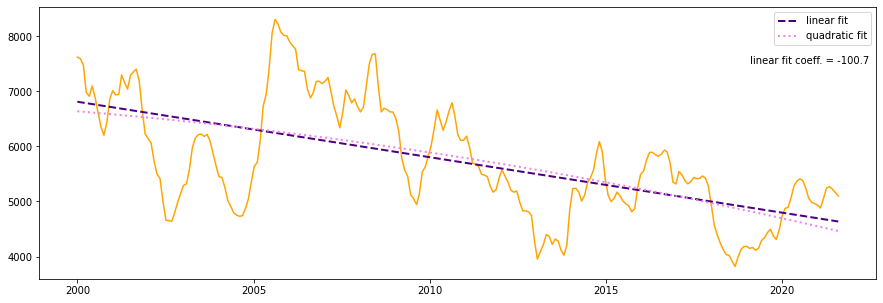

In [35]:
plt.figure(figsize=(15,5))
plt.plot(x_axis, y_fires, color="orange")
plt.plot(x_axis, p_fires_1(x_axis), linestyle="dashed", linewidth=2, color="indigo", label="linear fit")
plt.plot(x_axis, p_fires_2(x_axis), linestyle="dotted", linewidth=2, color="violet", label="quadratic fit")
plt.text(2019.1, 7500, "linear fit coeff. = {}".format(round(z_fires_1[0], 1)))
plt.legend()
plt.show()

In [36]:
# We apply the same analysis to the other two features:
z_force_1 = np.polyfit(x_axis, y_force, 1)
p_force_1 = np.poly1d(z_force_1)
print("best fit eq:")
print(p_force_1)
print("")
print(f"slope: {round(z_force_1[0])} acres burned per fire every year")
print("")
z_force_2 = np.polyfit(x_axis, y_force, 2)
p_force_2 = np.poly1d(z_force_2)
print("best fit eq:")
print(p_force_2)
print("")

best fit eq:
 
2.717 x - 5367

slope: 3 acres burned per fire every year

best fit eq:
        2
0.1726 x - 691.3 x + 6.924e+05



In [37]:
z_acres_1 = np.polyfit(x_axis, y_acres, 1)
p_acres_1 = np.poly1d(z_acres_1)
print("best fit eq:")
print(p_acres_1)
print("")
print(f"slope: {round(z_acres_1[0], 2)} total acres burned every year")
z_acres_2 = np.polyfit(x_axis, y_acres, 2)
p_acres_2 = np.poly1d(z_acres_2)
print("best fit eq:")
print(p_acres_2)
print("")

best fit eq:
 
5644 x - 1.076e+07

slope: 5644.35 total acres burned every year
best fit eq:
       2
113.8 x - 4.52e+05 x + 4.494e+08



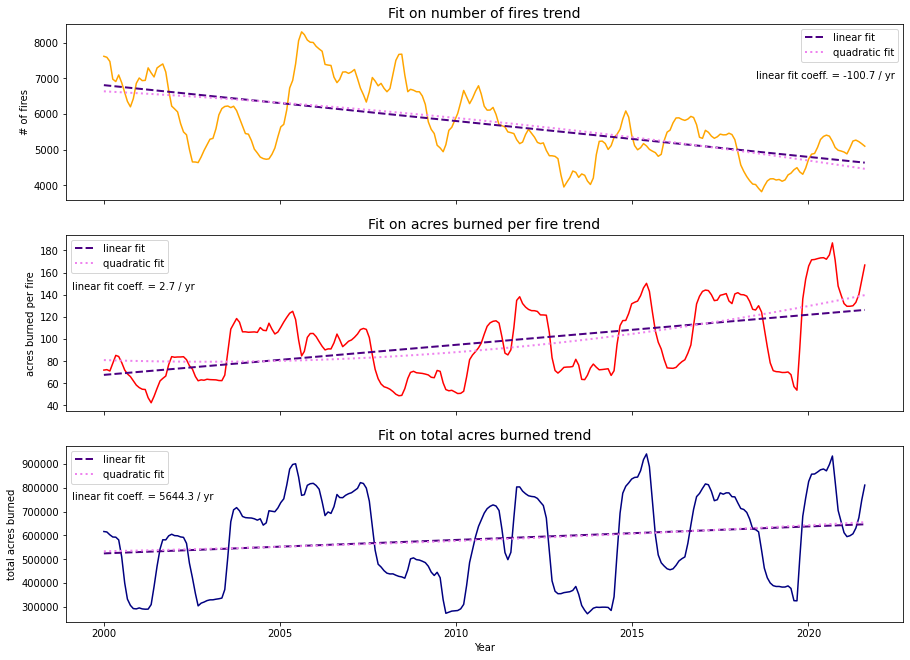

In [38]:
# Plots
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
fig.set_figheight(11)
fig.set_figwidth(15)

axes[0].set_title("Fit on number of fires trend", fontsize=14)
axes[0].set_ylabel("# of fires")
axes[0].plot(x_axis, y_fires, color="orange")
axes[0].plot(x_axis, p_fires_1(x_axis), linestyle="dashed", linewidth=2, color="indigo", label="linear fit")
axes[0].plot(x_axis, p_fires_2(x_axis), linestyle="dotted", linewidth=2, color="violet", label="quadratic fit")
axes[0].text(2018.5, 7000, "linear fit coeff. = {} / yr".format(round(z_fires_1[0], 1)))
axes[0].legend(loc='upper right');

axes[1].set_title("Fit on acres burned per fire trend", fontsize=14)
axes[1].set_ylabel("acres burned per fire")
axes[1].plot(x_axis, y_force, color="red")
axes[1].plot(x_axis, p_force_1(x_axis), linestyle="dashed", linewidth=2, color="indigo", label="linear fit")
axes[1].plot(x_axis, p_force_2(x_axis), linestyle="dotted", linewidth=2, color="violet", label="quadratic fit")
axes[1].text(1999.1, 145, "linear fit coeff. = {} / yr".format(round(z_force_1[0], 1)))
axes[1].legend(loc='upper left');

axes[2].set_title("Fit on total acres burned trend", fontsize=14)
axes[2].set_ylabel("total acres burned")
axes[2].plot(x_axis, y_acres, color="navy")
axes[2].plot(x_axis, p_acres_1(x_axis), linestyle="dashed", linewidth=2, color="indigo", label="linear fit")
axes[2].plot(x_axis, p_acres_2(x_axis), linestyle="dotted", linewidth=2, color="violet", label="quadratic fit")
axes[2].text(1999.1, 750000, "linear fit coeff. = {} / yr".format(round(z_acres_1[0], 1)))
axes[2].legend(loc='upper left');
axes[2].set_xlabel("Year")

plt.show()
